In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neat.fields import StellnaQS
from neat.tracing import ChargedParticle, ParticleOrbit
import itertools

In [2]:
# Useful function to switch rows with columns in a plot legend
def flip(items, ncol):
        return itertools.chain(*[items[i::ncol] for i in range(ncol)])

In [3]:
# Radial position of particles
s_i=np.array([0.25, 0.5, 0.75])
# Poloidal position of particles
theta_=np.array([0., np.pi, np.pi/2])
# Lambda ratio as x-coordinate
lambda_=np.arange(-1,1,100)

# Reactor setup
B0 = 5.3267         # ARIES-CS |B|
R_major = 7.7495*2  # ARIES-CS major radius x2
r_minor = 1.7044    # ARIES-CS minor radius

# List of working stellarators
stellarator = ["precise QA", "2022 QH nfp4 well"]

# QA scaled stellarator
g_field_basis_qa = StellnaQS.from_paper(stellarator[0], B0=B0, nphi=101)
g_field_qa = StellnaQS(
        rc=g_field_basis_qa.rc * R_major,
        zs=g_field_basis_qa.zs * R_major,
        etabar=g_field_basis_qa.etabar / R_major,
        B2c=g_field_basis_qa.B2c * (B0 / R_major / R_major),
        B0=B0,
        nfp=g_field_basis_qa.nfp,
        order="r3",
        nphi=101,
    )

# QH scaled stellarator
g_field_basis_qh = StellnaQS.from_paper(stellarator[1], B0=B0, nphi=101)
g_field_qh = StellnaQS(
        rc=g_field_basis_qh.rc * R_major,
        zs=g_field_basis_qh.zs * R_major,
        etabar=g_field_basis_qh.etabar / R_major,
        B2c=g_field_basis_qh.B2c * (B0 / R_major / R_major),
        B0=B0,
        nfp=g_field_basis_qh.nfp,
        order="r3",
        nphi=101,
    )

etabar_qa=g_field_qa.etabar
etabar_qh=g_field_qh.etabar
# print(etabar_qa)
# print(etabar_qh)

In [4]:
# Number of field periods
nfp_qa=g_field_qa.nfp

# Initial radial positions
s_initials = np.round(s_i, 2) # psi/psi_a for vmec

# Initial values for lambdas
lambdas=np.round(np.arange(0.05,0.8,0.1), 2) # = mu * B0 / energy
lambdas=np.concatenate((lambdas,np.round(np.arange(0.8,0.991,0.01), 2)))
# Initial angular values
theta_initials=np.round(np.arange(0,np.pi+0.01,np.pi/2), 2)         # initial poloidal angle (vartheta=theta_Boozer - N phi_Boozer)
phi_initials=np.round(np.arange(0,2*np.pi/nfp_qa,2*np.pi/nfp_qa/2), 2)    # initial toroidal angle (cylindrical on axis)

#Particle values
B0 = 5.3267          # Tesla, magnetic field on-axis (ARIES-CS)
energy = 3.52e6      # electron-volt
charge = 2           # times charge of proton
mass = 4             # times mass of proton
nsamples = 2000      # resolution in time
tfinal = 4e-4        # seconds
constant_b20 = False # use a constant B20 (mean value) or the real function

g_orbits_qa = [
    ParticleOrbit(
        ChargedParticle(
            r_initial=r_minor*np.sqrt(s_initial),
            theta_initial=theta_initial-(g_field_qa.iota-g_field_qa.iotaN)*phi_initial,
            phi_initial=phi_initial,
            energy=energy,
            Lambda=lambdas[i],
            charge=charge,
            mass=mass,
            vpp_sign=vpp_sign,
        ),
        g_field_qa,
        nsamples=nsamples,
        tfinal=tfinal,
        constant_b20=constant_b20
    )
    for i in np.arange(lambdas.size)
    for s_initial in s_initials
    for theta_initial in theta_initials
    for phi_initial in phi_initials
    for vpp_sign in [+1,-1]
]

In [5]:
g_orbits_qh = [
    ParticleOrbit(
        ChargedParticle(
            r_initial=r_minor*np.sqrt(s_initial),
            theta_initial=theta_initial-(g_field_qh.iota-g_field_qh.iotaN)*phi_initial,
            phi_initial=phi_initial,
            energy=energy,
            Lambda=lambdas[i],
            charge=charge,
            mass=mass,
            vpp_sign=vpp_sign,
        ),
        g_field_qh,
        nsamples=nsamples,
        tfinal=tfinal,
        constant_b20=constant_b20
    )
    for i in np.arange(lambdas.size)
    for s_initial in s_initials
    for theta_initial in theta_initials
    for phi_initial in phi_initials
    for vpp_sign in [+1,-1]
]

In [6]:
# Values used for the Estimated Orbit Amplitude analysis 

# QA
stuff_qa=[(
    (np.max((g_orbits_qa[i].r_pos/r_minor)**2) - \
       np.min((g_orbits_qa[i].r_pos/r_minor)**2))/2,
    g_orbits_qa[i].particle.theta_initial,
    g_orbits_qa[i].particle.Lambda,
    g_orbits_qa[i].particle.r_initial,
    g_orbits_qa[i].particle.vpp_sign,
    (g_orbits_qa[i].r_pos[-1] > r_minor*np.sqrt(0.998)),
 ) for i in range(len(g_orbits_qa))]

# Switching rows with columns
stuff_qa=np.einsum('ij->ji',stuff_qa)

# QH
stuff_qh=[(
    (np.max((g_orbits_qh[i].r_pos/r_minor)**2) - \
       np.min((g_orbits_qh[i].r_pos/r_minor)**2))/2,
    g_orbits_qh[i].particle.theta_initial,
    g_orbits_qh[i].particle.Lambda,
    g_orbits_qh[i].particle.r_initial,
    g_orbits_qh[i].particle.vpp_sign,
    (g_orbits_qh[i].r_pos[-1] > r_minor*np.sqrt(0.998)),
 ) for i in range(len(g_orbits_qh))]

# Switching rows with columns
stuff_qh=np.einsum('ij->ji',stuff_qh)

/tmp/ipykernel_13733/241581664.py:56: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \


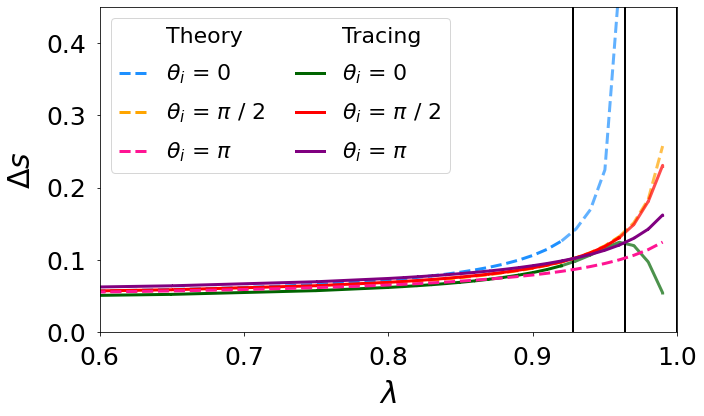

/tmp/ipykernel_13733/241581664.py:56: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \


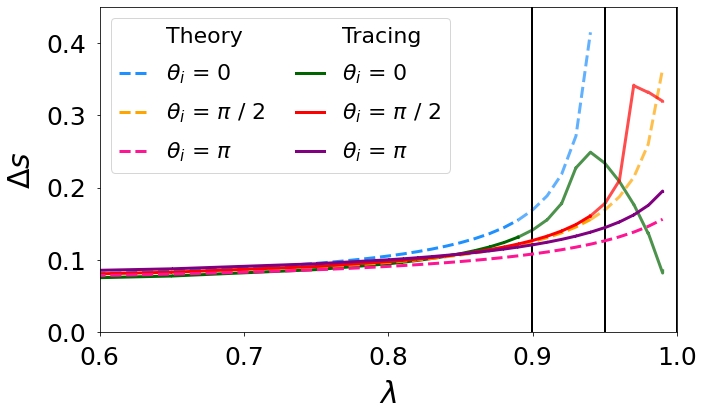

/tmp/ipykernel_13733/241581664.py:56: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \


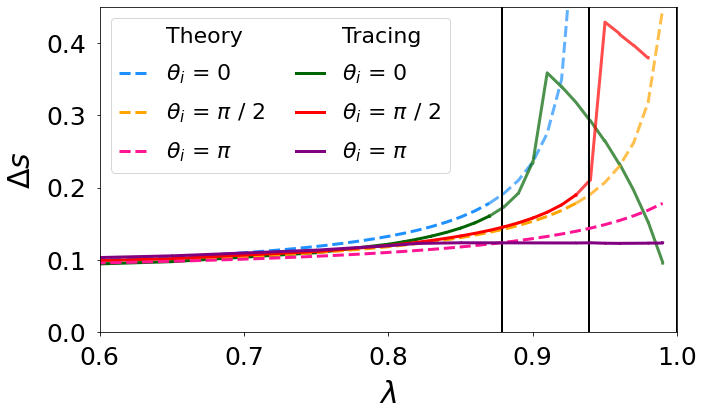

In [20]:
#QA
import neat.constants as cnst

# Setting x axis
lambda_array=np.arange(0,1,1/100)

# Configuration relevant values
delta_s=0.2
l=g_field_qa.axis_length
iota_N_qa=g_field_qa.iotaN

# Constants in SI units
charge = cnst.ALPHA_PARTICLE_CHARGE         # charge N times charge of proton
mass = cnst.ALPHA_PARTICLE_MASS             # mass N times mass of proton    
energy = cnst.FUSION_ALPHA_PARTICLE_ENERGY  # electron-volt

A= mass*l*np.sqrt(energy/(2*mass))*abs(etabar_qa) / (np.pi*charge*iota_N_qa) # Constant value for theoretical estimation
psi_b=0.5*B0*r_minor**2 # Last closed surface toroidal flux in 1st order NAE - Normalization factor
D=A/(psi_b) 

#Colors
colors=['dodgerblue', 'darkgreen', 'orange', 'red', 'deeppink', 'purple']

for s_initial in s_i:
    fig,ax=plt.subplots(figsize=(10, 6))
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('font', size=14)
    plt.rc('legend', fontsize=14)
    plt.rc('lines', linewidth=3)
    r=r_minor*np.sqrt(s_initial)
    c=0 # Value setting colors
    for theta in [0,np.pi/2,np.pi]:
    
        theta=round(theta,2)
        # Pretty legend for pi
        if theta==0:
            theta_str=str(theta)
        elif theta==1.57:
            theta_str=r'$\pi \ / \ 2$'
        else:
            theta_str=r'$\pi$'

        # T-P Threshold with 1st order near axis fields
        B_i = 1 + r*etabar_qa*np.cos(theta) # initial field
        B_mid = 1 + r_minor*np.sqrt(s_initial)*abs(etabar_qa) # mid threshold field
        Bar=B_i/B_mid

        # Ploting before the T-P Threshold
        # Theoretical amplitude value
        a=lambda_array/(1+r*etabar_qa*np.cos(theta))
        # plt.plot(lambda_array[lambda_array<=Bar],D*(r - 0.5*r_minor*(np.sqrt(delta_s+s_initial)-np.sqrt(s_initial))*np.cos(theta))*(1 - 0.5*a[lambda_array<=Bar])/np.sqrt(1 - a[lambda_array<=Bar]) \
                # ,'--' ,label=rf'$\theta_i$ = {theta_str}')
        plt.plot(lambda_array[lambda_array<=Bar],D*(r)*(1 - 0.5*a[lambda_array<=Bar])/np.sqrt(1 - a[lambda_array<=Bar]) \
                ,'--' ,c=colors[c],label=rf'$\theta_i$ = {theta_str}')
        plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \
        ,'--',c=colors[c],alpha=0.7)
        c+=1
        # Computed amplitude value        
        plt.plot(stuff_qa[2][(stuff_qa[3]==r) & (stuff_qa[1] == theta) & \
        (stuff_qa[4] == 1 ) & (stuff_qa[5]==0) & (stuff_qa[2]<=Bar)],stuff_qa[0][(stuff_qa[3]==r) & (stuff_qa[1] == theta) & \
        (stuff_qa[4] == 1 ) & (stuff_qa[5]==0) & (stuff_qa[2]<=Bar)],c=colors[c], label= rf'$\theta_i$ = {theta_str}')
        
        # Ploting after the T-P Threshold
        # Theoretical amplitude value
        # plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r - 0.5*r_minor*(np.sqrt(delta_s+s_initial)-np.sqrt(s_initial))*np.cos(theta))*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \
        # ,'--',c='C'+ str(c),alpha=0.7)
        
        
        # Computed amplitude value
        plt.plot(stuff_qa[2][(stuff_qa[3]==r) & (stuff_qa[1] == theta) & \
        (stuff_qa[4] == 1 ) & (stuff_qa[5]==0)  & (stuff_qa[2]>=Bar-0.01)],stuff_qa[0][(stuff_qa[3]==r) & (stuff_qa[1] == theta) & \
        (stuff_qa[4] == 1 ) & (stuff_qa[5]==0)  & (stuff_qa[2]>=Bar-0.01)], c=colors[c],alpha=0.7)
        c+=1
        plt.axvline(Bar,c='k',ls='-',lw=2)
    
    # Ploting configs
    plt.xlim(0.6,1)
    plt.ylim(0,0.45)
    handles, labels = ax.get_legend_handles_labels()
    plt.tick_params(axis='x', labelsize=25,pad=10)
    plt.xlabel(r'$\lambda$',fontsize=30,labelpad=10)
    plt.tick_params(axis='y', labelsize=25,pad=10)
    plt.ylabel(r'$\Delta s$',fontsize=30,labelpad=10)
    ph = [plt.plot([],marker="", ls="")[0]]*2
    handles = ph + handles 
    labels = ["Theory", "Tracing"] + labels 
    plt.legend(flip(handles, 2), flip(labels, 2), fontsize=22,ncols=2,handlelength=1.3, labelspacing=0.7, columnspacing=1.4, loc=2)
    plt.tight_layout()
    plt.savefig(f'Theoretical_QA_Amplitude_Prediction_s_i={s_initial}_last_bar.pdf')
    plt.show()

/tmp/ipykernel_13733/3852148440.py:54: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \


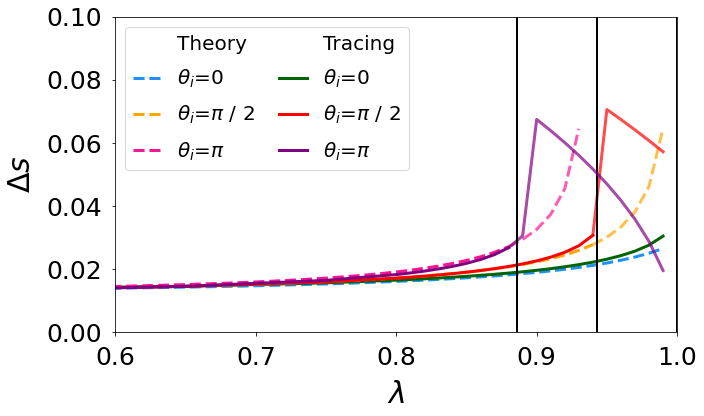

/tmp/ipykernel_13733/3852148440.py:54: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \


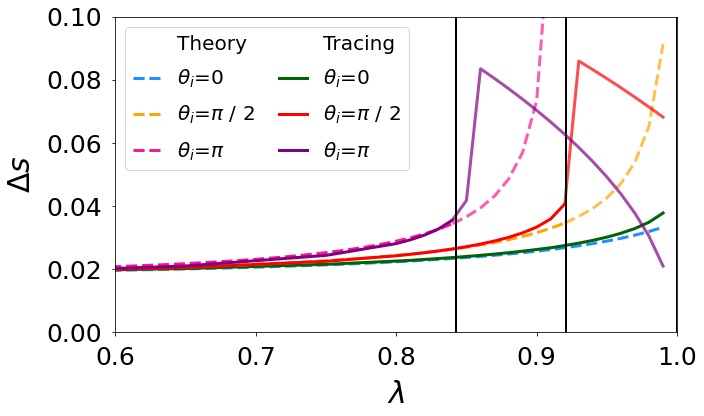

/tmp/ipykernel_13733/3852148440.py:54: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \


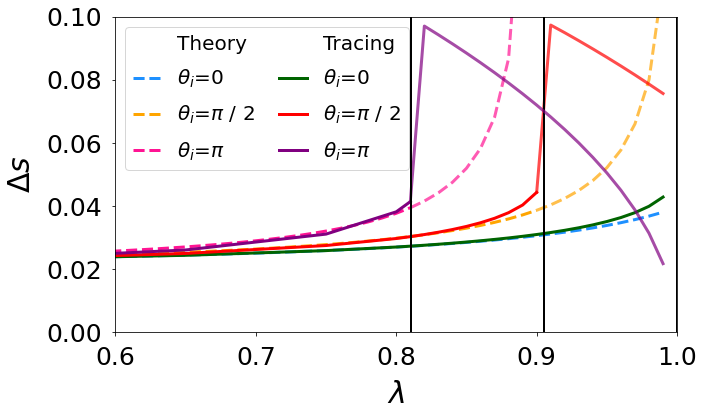

In [19]:
#QH
import neat.constants as cnst

# Setting x axis
lambda_array=np.arange(0,1,1/100)

# Configuration relevant values
l=g_field_qh.axis_length
iota_N_qh=g_field_qh.iotaN
delta_s=0.05

# Constants in SI units
charge = cnst.ALPHA_PARTICLE_CHARGE         # charge N times charge of proton
mass = cnst.ALPHA_PARTICLE_MASS             # mass N times mass of proton    
energy = cnst.FUSION_ALPHA_PARTICLE_ENERGY  # electron-volt

A= mass*l*np.sqrt(energy/(2*mass))*etabar_qh / (np.pi*charge*iota_N_qh) # Non normalized value for theoretical estimation
psi_b=0.5*B0*r_minor**2 # Last closed surface toroidal flux in 1st order NAE - Normalization factor
D=A/psi_b

#Colors
colors=['dodgerblue', 'darkgreen', 'orange', 'red', 'deeppink', 'purple']


for s_initial in s_i:
    fig,ax=plt.subplots(figsize=(10, 6))
    plt.rc('xtick', labelsize=14)
    plt.rc('ytick', labelsize=14)
    plt.rc('font', size=14)
    plt.rc('legend', fontsize=14)
    plt.rc('lines', linewidth=3)
    r=r_minor*np.sqrt(s_initial)
    c=0
    for theta in [0,np.pi/2,np.pi]:
        theta=round(theta,2)
        a=lambda_array/(1+r*etabar_qh*np.cos(theta))
        
        if theta==0:
            theta_str=str(theta)
        elif theta==1.57:
            theta_str=r'$\pi \ / \ 2$'
        else:
            theta_str=r'$\pi$'
        
        # 1st order near axis fields
        B_i = 1 + r*etabar_qh*np.cos(theta) # initial field
        B_mid = 1 + r*abs(etabar_qh) # mid threshold field
        Bar=B_i/B_mid
        
        # plt.plot(lambda_array[lambda_array<=Bar],D*(r + 0.5*r_minor*(np.sqrt(delta_s+s_initial)-np.sqrt(s_initial))*np.cos(theta))*(1 - 0.5*a[lambda_array<=Bar])/np.sqrt(1 - a[lambda_array<=Bar]) \
        #         ,'--',label=rf'$\theta_i$={theta_str}')
        plt.plot(lambda_array[lambda_array<=Bar],D*(r)*(1 - 0.5*a[lambda_array<=Bar])/np.sqrt(1 - a[lambda_array<=Bar]) \
                ,'--',c=colors[c],label=rf'$\theta_i$={theta_str}')
        plt.plot(lambda_array[lambda_array>=Bar-0.01],D*(r)*(1 - 0.5*a[lambda_array>=Bar-0.01])/np.sqrt(1 - a[lambda_array>=Bar-0.01]) \
                ,'--',c=colors[c],alpha=0.7)
        c+=1
        plt.plot(stuff_qh[2][(stuff_qh[3]==r) & (stuff_qh[1] == theta) & \
        (stuff_qh[4] == 1 ) & (stuff_qh[5]==0)  & (stuff_qh[2]<=Bar)],stuff_qh[0][(stuff_qh[3]==r) & (stuff_qh[1] == theta) & \
        (stuff_qh[4] == 1 ) & (stuff_qh[5]==0)  & (stuff_qh[2]<=Bar)],c=colors[c], label= rf'$\theta_i$={theta_str}')
        
        plt.plot(stuff_qh[2][(stuff_qh[3]==r) & (stuff_qh[1] == theta) & \
        (stuff_qh[4] == 1 ) & (stuff_qh[5]==0)  & (stuff_qh[2]>=Bar-0.01)],stuff_qh[0][(stuff_qh[3]==r) & (stuff_qh[1] == theta) & \
        (stuff_qh[4] == 1 ) & (stuff_qh[5]==0)  & (stuff_qh[2]>=Bar-0.01)], c=colors[c],alpha=0.7)
        c+=1
        plt.axvline(Bar,c='k',ls='-',lw=2)
    plt.ylim(0,0.1)
    plt.xlim(0.6,1)
    # plt.title(f'Theoretical QH Amplitude Prediction s_i={s_initial}')
    handles, labels = ax.get_legend_handles_labels()
    plt.tick_params(axis='x', labelsize=25,pad=10)
    plt.xlabel(r'$\lambda$',fontsize=30,labelpad=10)
    plt.tick_params(axis='y', labelsize=25,pad=10)
    plt.ylabel(r'$\Delta s$',fontsize=30,labelpad=10)
    ph = [plt.plot([],marker="", ls="")[0]]*2
    handles = ph + handles 
    labels = ["Theory", "Tracing"] + labels 
    plt.legend(flip(handles, 2), flip(labels, 2), fontsize=20,ncols=2,handlelength=1.4, labelspacing=0.7, columnspacing=1.2, loc=2)
    plt.tight_layout()
    plt.savefig(f'Theoretical_QH_Amplitude_Prediction_s_i={s_initial}_last_bar.pdf')
    plt.show()